In [69]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [70]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [71]:
NUM_CLASSES = 8

# Dataset reading

In [72]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [73]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [76]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [78]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [79]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
189/192 [============================>.] - ETA: 0s - loss: 1.4429 - accuracy: 0.5150
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
192/192 [==============================] - 2s 8ms/step - loss: 1.4365 - accuracy: 0.5165 - val_loss: 0.7841 - val_accuracy: 0.8151
Epoch 2/1000
188/192 [============================>.] - ETA: 0s - loss: 0.8365 - accuracy: 0.7014
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
192/192 [==============================] - 2s 9ms/step - loss: 0.8339 - accuracy: 0.7023 - val_loss: 0.5205 - val_accuracy: 0.9146
Epoch 3/1000
192/192 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.7730
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
192/192 [==============================] - 1s 5ms/step - loss: 0.6735 - accuracy: 0.7730 - val_loss: 0.3734 - val_accuracy: 0.9404
Epoch 4/1000
181/192 [===========================>..] - ETA: 0s - loss: 0.5873 - accu

In [80]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

64/64 [==============================] - 0s 3ms/step - loss: 0.2008 - accuracy: 0.9536


In [81]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [82]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 110ms/step
[5.8087921e-09 1.0194082e-03 1.5800705e-04 5.2439667e-02 7.9309754e-03
 4.8234879e-06 9.3844658e-01 4.7542278e-07]
6


# Confusion matrix

256/256 [==============================] - 1s 2ms/step


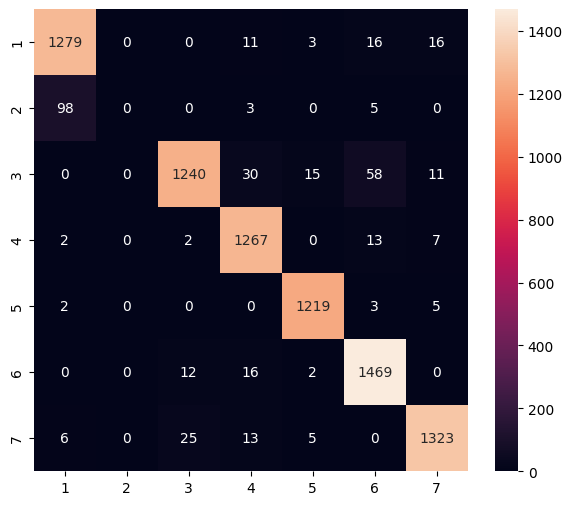

Classification Report
              precision    recall  f1-score   support

           1       0.92      0.97      0.94      1325
           2       0.00      0.00      0.00       106
           3       0.97      0.92      0.94      1354
           4       0.95      0.98      0.96      1291
           5       0.98      0.99      0.99      1229
           6       0.94      0.98      0.96      1499
           7       0.97      0.96      0.97      1372

    accuracy                           0.95      8176
   macro avg       0.82      0.83      0.82      8176
weighted avg       0.94      0.95      0.95      8176



/home/jjc257/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jjc257/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jjc257/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [84]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [85]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpk9_yjc8x/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9_yjc8x/assets
2022-12-12 17:31:19.978109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-12 17:31:19.978133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-12 17:31:19.978259: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk9_yjc8x
2022-12-12 17:31:19.979810: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-12 17:31:19.979842: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk9_yjc8x
2022-12-12 17:31:19.986724: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-12 17:31:20.050782: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk9_yjc8x
2022-12-12 17:31:20.068330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6772

# Inference test

In [86]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [87]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [88]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [89]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 315 µs, sys: 22 µs, total: 337 µs
Wall time: 288 µs


In [90]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.8087921e-09 1.0194083e-03 1.5800723e-04 5.2439652e-02 7.9309763e-03
 4.8234888e-06 9.3844670e-01 4.7542326e-07]
6
